In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
# using BenchmarkTools
import ProgressMeter
using LinearAlgebra

## Switching AR

In [566]:
@model [ default_factorisation = MeanField() ] function switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                     priors_as, priors_bs,
                                                                     priors_ms, priors_ws)

    n = length(outputs)
    @show n
    A ~ MatrixDirichlet(ones(nmixtures, nmixtures))

    z_0 ~ Categorical(fill(1.0 / nmixtures, nmixtures))

    as = randomvar(nmixtures, prod_strategy = FoldRightProdStrategy(), constraint=EM())
    bs = randomvar(nmixtures, prod_strategy = FoldRightProdStrategy())
    ms = randomvar(nmixtures)
    ws = randomvar(nmixtures)

    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
        ms[i] ~ MvNormalMeanCovariance(mean(priors_ms[i]), cov(priors_ms[i]))
        ws[i] ~ Wishart(priors_ws[i][1], priors_ws[i][2])
    end

    z  = randomvar(nbuckets)
    γ  = randomvar(nbuckets)
    θ  = randomvar(nbuckets)
    dp = randomvar(n)
    x  = datavar(Vector{Float64}, n)
    y  = datavar(Float64, n)

    meta = GammaMixtureNodeMetadata(EM())

    tas = tuple(as...)
    tbs = tuple(bs...)
    tms = tuple(ms...)
    tws = tuple(ws...)

    z_prev = z_0
    for i in 1:nbuckets
        z[i] ~ Transition(z_prev, A) where { q = q(out, in)q(a) }
        γ[i] ~ GammaMixture(z[i], tas, tbs) where { meta = meta }
        θ[i] ~ GaussianMixture(z[i], tms, tws) where { q = MeanField() }
        z_prev = z[i]
    end
    
    k = div(n + ARorder, nbuckets)
    @show k
    i = 0
    for i in 1:n
        r     = div(i - 1, k) + 1
        dp[i] ~ dot(x[i], θ[r]) where { q = MeanField() }
        y[i]  ~ NormalMeanPrecision(dp[i], γ[r]) 
    end

    scheduler = schedule_updates(as, bs, ms, ws)

    return scheduler, z, A, as, bs, ms, ws, θ, γ, y, x
end

switching_ar (generic function with 1 method)

In [573]:
function inference_ar(inputs, outputs, nmixtures, nbuckets, n_its, priors_as, priors_bs, priors_ms, priors_ws)
    n = length(outputs)
    ARorder = size(priors_ms[1])[1]

    model, (scheduler, z, A, as, bs, ms, ws, θs, γs, y, x) = switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                          priors_as, priors_bs,
                                                                          priors_ms, priors_ws, options=(limit_stack_depth=100,));
    

    mzs     = keep(Vector{Marginal})
    mA      = keep(Marginal)
    mas     = keep(Vector{Marginal})
    mbs     = keep(Vector{Marginal})
    mms     = keep(Vector{Marginal})
    mws     = keep(Vector{Marginal})
    mθs     = keep(Vector{Marginal})
    mγs     = keep(Vector{Marginal})
    fe      = ScoreActor(Float64)

    mA_sub     = subscribe!(getmarginal(A), mA)
    mz_sub     = subscribe!(getmarginals(z), mzs)
    as_sub     = subscribe!(getmarginals(as), mas)
    bs_sub     = subscribe!(getmarginals(bs), mbs)
    ms_sub     = subscribe!(getmarginals(ms), mms)
    ws_sub     = subscribe!(getmarginals(bs), mws)
    θs_sub     = subscribe!(getmarginals(θs), mθs)
    γs_sub     = subscribe!(getmarginals(γs), mγs)

    # fe_scheduler = PendingScheduler()
    fe_sub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    setmarginal!(A, vague(MatrixDirichlet, (nmixtures, nmixtures)))

    for (a, b, m, w) in zip(as, bs, ms, ws)
        setmarginal!(a, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(b, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(m, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(w, vague(Wishart, ARorder))
    end

    for (θ, γ) in zip(θs, γs)
        setmarginal!(θ, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(γ, vague(Gamma))
    end

    release!(scheduler)
    
    ProgressMeter.@showprogress for i in 1:n_its
        update!(x, inputs)
        update!(y, outputs)
        release!(scheduler)
        # release!(fe_scheduler)
    end


    return map(getvalues, (mzs, mγs, mθs, mA, mas, mbs, mms, mws, fe))
end

inference_ar (generic function with 1 method)

In [574]:
ReactiveMP.release!(::Nothing) = nothing

## Generate AR

In [575]:
using Random

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions
ARorder = 2

γs = [1.0, 1.0]
# γs = [0.01, 0.1, 10.0, 1.0]
θs = [[0.599, 0.0], [-0.989, 0.0]]
# θs = [0.9, 0.3, -0.3, 0.1]

@assert length(γs) == length(θs)

nmixtures = length(γs)
n_samples = 1000
x = ones(ARorder)
x = [1.0, 2.0]

n_slice_n = 100

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end

inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
;

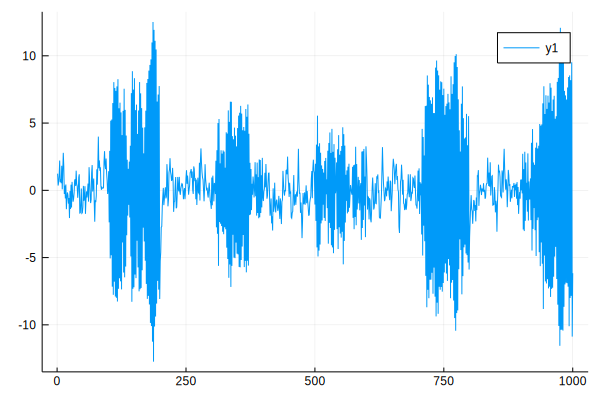

In [576]:
using Plots
plot(outputs)

In [577]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:end-ARorder]

998-element Vector{Float64}:
   1.2381867766038972
   0.355940497432735
   0.6023581919931569
   1.0896120508989353
   2.213175136559684
   0.6146950583694045
   0.721763222181288
   0.5293622498477434
   1.8264154483945678
   0.07297579334414506
   1.4557426312051258
   2.786176933152733
   1.7898110119174175
   ⋮
  -6.863997558351042
   6.74775785871742
  -6.903192522172789
   7.64885314452348
  -7.160789461651885
   8.425047176155575
 -10.100597295322357
   8.544027105707803
  -7.998947098841741
   8.193449020864252
  -7.84353370534234
   9.51779856165006

In [578]:
csep = 10.0

priors_as = map(γ -> infgamma(Float64, γ*csep), γs)
priors_bs = map(_ -> infgamma(Float64, csep), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ, diageye(ARorder)), θs)
priors_ws = map(_ -> (ARorder, 1e4*diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))

@time mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_ar(inputs_, outputs_, nmixtures, 100, 100, priors_as, priors_bs, priors_ms, priors_ws);

n = 998
k = 10


LoadError: MethodError: no method matching rule(::Type{NormalMixture{2}}, ::Type{Val{:out}}, ::Marginalisation, ::Nothing, ::Nothing, ::Type{Val{(:switch, :m, :p)}}, ::Tuple{Marginal{Categorical{Float64, Vector{Float64}}}, Tuple{Marginal{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}, Marginal{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}}, Tuple{Marginal{Wishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}, Int64}}, Marginal{Wishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}, Int64}}}}, ::Nothing, ::NormalMixtureNode{2, MeanField, Nothing, EmptyPortal})
[0mClosest candidates are:
[0m  rule(::Any, ::Any, [91m::ExpectationMaximisation[39m, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) at /Users/apodusenko/.julia/dev/ReactiveMP/src/rules/common/em.jl:4
[0m  rule(::Type{var"#s234"} where var"#s234"<:NormalMixture{N}, ::Type{Val{:out}}, ::Marginalisation, ::Nothing, ::Nothing, ::Type{Val{(:switch, :m, :p)}}, [91m::Tuple{Marginal{var"#s233"} where var"#s233", Tuple{Vararg{var"#s232", N}} where var"#s232"<:(Marginal{var"#s231"} where var"#s231"<:(Union{UnivariateGaussianDistributionsFamily{T}, UnivariateNormalDistributionsFamily{T}} where T)), Tuple{Vararg{var"#s230", N}} where var"#s230"<:(Marginal{var"#s229"} where var"#s229"<:(GammaDistributionsFamily{T} where T))}[39m, ::Any, ::Any) where N at /Users/apodusenko/.julia/dev/ReactiveMP/src/rule.jl:79
[0m  rule(::Type{var"#s234"} where var"#s234"<:NormalMixture{N}, [91m::Type{Val{:switch}}[39m, ::Marginalisation, ::Nothing, ::Nothing, [91m::Type{Val{(:out, :m, :p)}}[39m, ::Tuple{Marginal{var"#s233"} where var"#s233", Tuple{Vararg{var"#s232", N}} where var"#s232"<:(Marginal{var"#s231"} where var"#s231"<:(Union{MultivariateGaussianDistributionsFamily{T}, MultivariateNormalDistributionsFamily{T}} where T)), Tuple{Vararg{var"#s230", N}} where var"#s230"<:(Marginal{var"#s229"} where var"#s229"<:Wishart)}, ::Any, ::Any) where N at /Users/apodusenko/.julia/dev/ReactiveMP/src/rule.jl:79
[0m  ...

In [554]:
div(4990, 10) + 1

500

In [359]:
mean(mA[end])

LoadError: UndefVarError: mA not defined

In [63]:
minimum(mean.(mγs[end]))

0.14452848208297758

In [64]:
using Plots

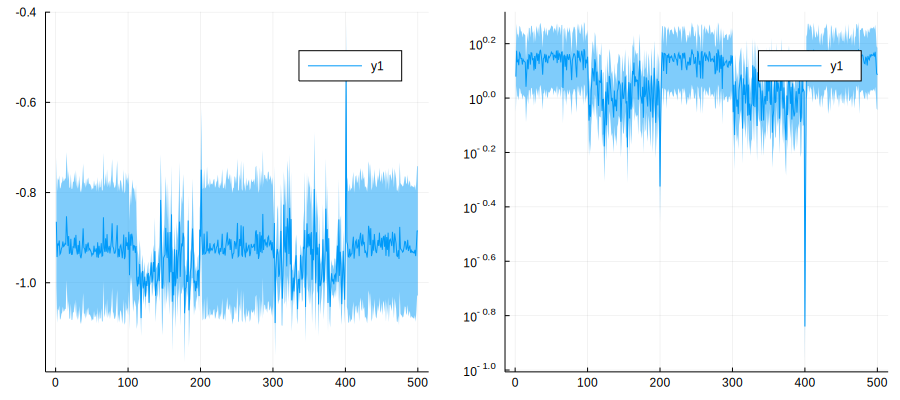

In [65]:
p1 = plot(mean.(mθs[end]), ribbon = std.(mθs[end]))
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10)

plot(p1, p2, size = (900, 400))

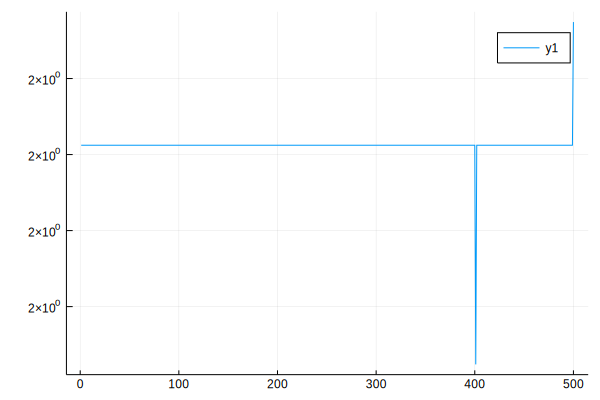

In [66]:
plot(mean.(mzs[end]))

In [67]:
mean.(mzs[end])

500-element Vector{Float64}:
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 ⋮
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999985305
 1.9999999999989355

mfe[end - 4:end] = [6018.376419579305, 6018.376419580261, 6018.376419580149, 6018.3764195800395, 6018.376419580298]


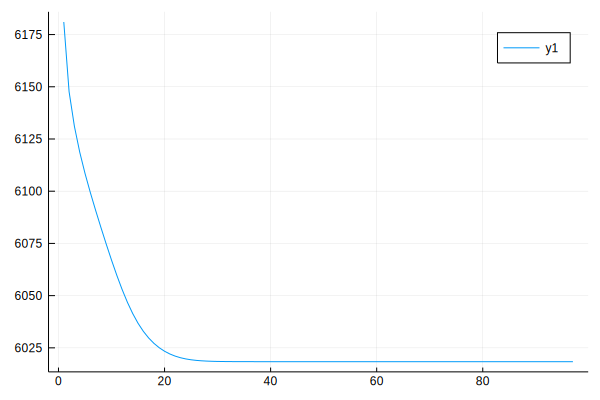

In [68]:
@show mfe[end-4:end]
plot(mfe[4:end])